### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

### Task description
Some traces may be inversed because of the sensor failure. Using first break piking model and some features from traces we train RandomForest to solve the problem.

### Generated dataset discription
Let's have a look on the features that will be used for inverse traces detection. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* offset
* the difference between amplitude value on the N traces of neighors
* the difference between time value of the first break picking on the N traces of neighbors
* correlation between part of traces with first break picking points.

In [1]:
import sys
import torch
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, 
                            merge_picking_files, seismic_plot, KNNIndex)
from inverse_batch import InverseBatch
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Data

Firstly have a look on the data. Let's draw some of traces and try to guess the inverse trace.

In [2]:
path_raw = '/raw/path/'
markup_path = '/markup/path/'

index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset'], markup_path=markup_path))

batch = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         ).next_batch(1)
field = batch.raw[0]
mask = np.ones(len(field))
ix = np.random.choice(len(mask))
mask[ix] = -1
inv_field = np.array([trace * mask[i] for i, trace in enumerate(field)])

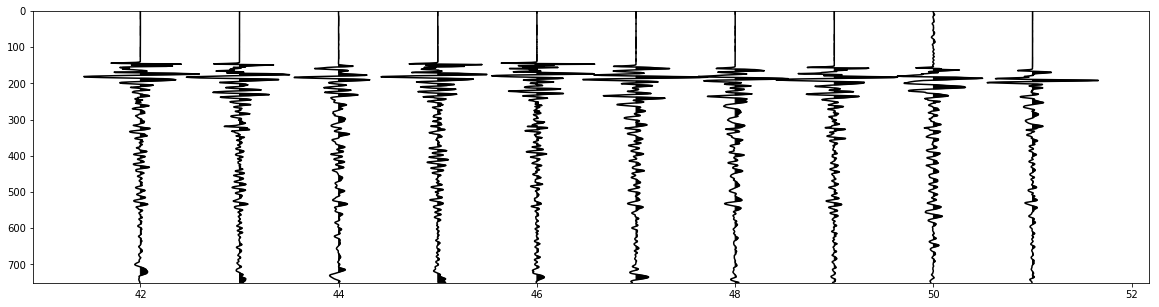

In [3]:
left = np.random.randint(0, 10)
right = 10 - left
seismic_plot(inv_field, cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
             figsize=(20, 5), std=0.1, xlim=(ix-left, ix+right))

In [4]:
print('Inverse trace is {}.'.format(ix))

Inverse trace is 44.


### Preprocessing

Firstly we load pretrained first break piking model.

In [5]:
model_path = '/model/path/'

model_ppl = Pipeline().init_model('dynamic', UNet, 'my_model',
                            config={'load' : {'path' : model_path},
                                    'build': False, 'device': 'cuda'})

model = model_ppl.get_model_by_name('my_model').model

Define pipeline and generate the dataset.

In [6]:
N_NEIGH = 7
SIZE = 20

def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [ ]:
%%time
z = ppl.next_batch(10)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
dataset = np.nan_to_num(dataset)

X_train, X_test, y_train, y_test = train_test_split(dataset, target)

Have a look on the dataset.

In [15]:
gen_name = lambda name, n: [name + '_{}'.format(i) for i in range(n)]
columns = ['amplitude', 'offset', *gen_name('of_corr_left', N_NEIGH),
           *gen_name('of_corr_right', N_NEIGH), *gen_name('of_inv_corr_left', N_NEIGH),
           *gen_name('of_inv_corr_right', N_NEIGH), *gen_name('corr_left', N_NEIGH),
           *gen_name('corr_right', N_NEIGH), 
           *gen_name('inv_corr_left', N_NEIGH), *gen_name('inv_corr_right', N_NEIGH)]
df = pd.DataFrame(X_train, columns=columns)
print('Dataset shape is: {}\n'.format(df.shape))
df.head()

Dataset shape is: (12580, 58)



,amplitude,offset,of_corr_left_0,of_corr_left_1,of_corr_left_2,of_corr_left_3,of_corr_left_4,of_corr_left_5,of_corr_left_6,of_corr_right_0,...,inv_corr_left_4,inv_corr_left_5,inv_corr_left_6,inv_corr_right_0,inv_corr_right_1,inv_corr_right_2,inv_corr_right_3,inv_corr_right_4,inv_corr_right_5,inv_corr_right_6
0,3.165285,1739.0,-0.876875,-0.950221,0.712057,-0.913546,-0.381909,-0.694584,-0.789972,-0.937668,...,0.919122,0.399470,0.329636,0.092918,0.008510,0.269716,0.251074,0.971690,0.304015,0.075841
1,3.384232,1422.0,-0.032502,0.280986,0.467535,-0.707933,-0.746304,-0.354625,0.790672,-0.426034,...,0.840556,0.049654,0.575036,0.234403,0.729125,0.059265,0.153390,0.248765,-0.299464,0.231076
2,12.620180,190.0,-0.896213,-0.912784,0.311706,0.265359,-0.799343,-0.690606,-0.128840,0.003643,...,0.659726,0.886276,0.727565,0.862004,0.854147,0.764949,0.926121,0.901379,0.863969,0.920517
3,1.189144,1376.0,-0.952729,-0.988908,-0.886257,-0.807355,-0.750145,-0.962348,-0.755913,-0.942807,...,0.316470,0.961847,0.218275,0.238154,0.957747,0.445828,0.980948,0.982533,0.180629,0.329278
4,0.004608,1455.0,-0.299953,-0.168334,0.000000,0.645250,-0.177743,0.745279,0.239048,-0.565155,...,0.389796,0.673248,-0.308794,0.585973,0.827455,0.526910,0.376259,0.282805,-0.649212,-0.020858


### Train Model
Using dataset generated above let's train Random Forest alghoritm.

In [16]:
tree = RandomForestClassifier(n_estimators=200, n_jobs=4)
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [22]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.97      2129
        1.0       0.98      0.97      0.97      2065

avg / total       0.97      0.97      0.97      4194

Accuracy score: 0.972


And graw feature importance.

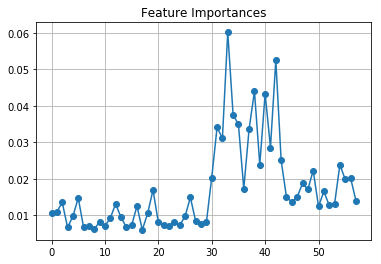

In [18]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)),
         tree.feature_importances_, marker='o')
plt.grid()

### Predict on one field

Let's inverse some traces in one filed and check how the model will find inverse traces.

In [19]:
ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   mode='predict', size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

In [22]:
batch = ppl.next_batch(1)

pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)

In [30]:
print(classification_report(pred_target, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(pred_target, pred)))
print('Number of inverse traces: {}'.format(sum(pred_target)))
print('Number of predict inverse traces: {}'.format(sum(pred)))
false_neg = sum(pred_target[np.where(pred_target != target)])
print('Number of missed inverse traces: {}'.format(false_neg))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       837
        1.0       0.50      1.00      0.67         3

avg / total       1.00      1.00      1.00       840

Accuracy score: 0.996
Number of inverse traces: 3.0
Number of predict inverse traces: 6.0
Number of missed inverse traces: 0.0


One can notice that there are many false positive predictions and zero false negative.